In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import requests
# from bs4 import BeautifulSoup
# import json
import time
import random
from fake_useragent import UserAgent

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# from sklearn.metrics import silhouette_score
# from scipy.cluster.hierarchy import dendrogram, linkage
# from scipy.spatial.distance import cdist

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Crawl Data 

In [3]:
def crawl_tiki_products(category_id=1789, num_pages=10):
    print(f"Data crawling from Tiki.vn (Category ID: {category_id})...")
    
    ua = UserAgent()
    products = []
    for page in range(1, num_pages + 1):
        try:
            # Tiki API endpoint
            url = f"https://tiki.vn/api/personalish/v1/blocks/listings?limit=40&category={category_id}&page={page}"
            headers = {
                'User-Agent': ua.random,
                'Accept': 'application/json, text/plain, */*',
                'Accept-Language': 'vi-VN,vi;q=0.9,en-US;q=0.8,en;q=0.7',
                'Referer': 'https://tiki.vn/',
                'x-guest-token': 'token'
            }
            response = requests.get(url, headers=headers, timeout=10)
            if response.status_code == 200:
                data = response.json()
                if 'data' in data:
                    for item in data['data']:
                        try:
                            product = {
                                'product_id': item.get('id', np.nan),
                                'name': item.get('name', 'Unknown'),
                                'price': item.get('price', 0),
                                'original_price': item.get('original_price', 0),
                                'discount': item.get('discount_rate', 0),
                                'rating': item.get('rating_average', 0),
                                'review_count': item.get('review_count', 0),
                                'sold_count': item.get('quantity_sold', {}).get('value', 0),
                                'brand': item.get('brand_name', 'Unknown'),
                                'category': category_id
                            }
                            products.append(product)
                        except Exception as e:
                            continue
                print(f"Finished crawling page {page}/{num_pages} - Total: {len(products)} products")
                time.sleep(random.uniform(1, 3))  # Tránh block
            else:
                print(f"Error page {page}: Status code {response.status_code}")
        except Exception as e:
            print(f"Error page {page}: {str(e)}")
            continue
    
    return pd.DataFrame(products)

Generate transactions data from products data

In [4]:
def generate_customer_transactions(df_products, n_customers=500, n_transactions=5000):
    # Từ tiki products, tạo dữ liệu giao dịch giả lập
    print("\nCreating customer transaction data")
    np.random.seed(42)
    transactions = []
    # Các nhóm khách hàng
    customer_segments = {
        'VIP': 
            {'n': int(n_customers * 0.1), 
             'freq_range': (10, 30), 
             'amount_multiplier': 2.5},
        'Regular': 
            {'n': int(n_customers * 0.3), 
             'freq_range': (5, 15), 
             'amount_multiplier': 1.5},
        'Occasional': 
            {'n': int(n_customers * 0.4), 
             'freq_range': (2, 8), 
             'amount_multiplier': 1.0},
        'One-time': 
            {'n': int(n_customers * 0.2), 
             'freq_range': (1, 3), 
             'amount_multiplier': 0.8}
    }
    customer_id = 10000
    transaction_id = 1
    
    for segment, config in customer_segments.items():
        for _ in range(config['n']):
            # Số lần mua
            n_purchases = np.random.randint(config['freq_range'][0], config['freq_range'][1])
            # Tạo giao dịch
            for purchase in range(n_purchases):
                # Chọn ngẫu nhiên 1-5 sản phẩm trong 1 lần mua
                n_items = np.random.randint(1, 6)
                selected_products = df_products.sample(n=min(n_items, len(df_products)))
                # Tạo thời gian giao dịch trong 12 tháng trước đó
                days_ago = np.random.randint(0, 365)
                transaction_date = datetime.now() - timedelta(days=days_ago)
                for _, product in selected_products.iterrows():
                    quantity = np.random.choice([1, 2, 3, 4], p=[0.6, 0.25, 0.1, 0.05])
                    # Giá thực tế (có thể có discount)
                    actual_price = product['price'] if product['price'] > 0 else product['original_price']
                    transaction = {
                        'transaction_id': f'TXN{transaction_id:06d}',
                        'customer_id': customer_id,
                        'product_id': product['product_id'],
                        'product_name': product['name'],
                        'quantity': quantity,
                        'unit_price': actual_price * config['amount_multiplier'],
                        'total_amount': actual_price * quantity * config['amount_multiplier'],
                        'transaction_date': transaction_date,
                        'brand': product['brand'],
                        'rating': product['rating'],
                        'customer_segment': segment
                    }
                    transactions.append(transaction)
                    transaction_id += 1
            customer_id += 1
    df_transactions = pd.DataFrame(transactions)
    # Giới hạn số giao dịch
    if len(df_transactions) > n_transactions:
        df_transactions = df_transactions.sample(n=n_transactions, random_state=42)
    print(f"Created {len(df_transactions):,} transactions from {df_transactions['customer_id'].nunique()} customers")
    return df_transactions

Crawling

In [5]:
print("DATA CRAWLING FROM TIKI.VN")
# Crawl 3 loại sản phẩm
categories = {
    1789: "Điện thoại - Máy tính bảng",
    1846: "Laptop - Máy vi tính",
    8322: "Đồng hồ"
}

all_products = []
for cat_id, cat_name in categories.items():
    print(f"\nCrawling category: {cat_name}")
    df_cat = crawl_tiki_products(category_id=cat_id, num_pages=5)
    all_products.append(df_cat)
    print(f"Crawled {len(df_cat)} product from {cat_name}")

# Gộp tất cả sản phẩm
df_products = pd.concat(all_products, ignore_index=True)
print(f"\nTotal product crawled: {len(df_products):,}")
# Lưu sản phẩm đã crawl
df_products.to_csv('tiki_products.csv', index=False, encoding='utf-8-sig')
print("Saved product list to 'tiki_products.csv'")
# Tạo dữ liệu giao dịch từ sản phẩm thật
df_raw = generate_customer_transactions(df_products, n_customers=500, n_transactions=5000)
# Lưu dữ liệu thô
df_raw.to_csv('raw_transactions.csv', index=False, encoding='utf-8-sig')
print("Save transactions data to 'raw_transactions.csv'")

DATA CRAWLING FROM TIKI.VN

Crawling category: Điện thoại - Máy tính bảng
Data crawling from Tiki.vn (Category ID: 1789)...
Finished crawling page 1/5 - Total: 40 products
Finished crawling page 2/5 - Total: 71 products
Finished crawling page 3/5 - Total: 90 products
Finished crawling page 4/5 - Total: 123 products
Finished crawling page 5/5 - Total: 143 products
Crawled 143 product from Điện thoại - Máy tính bảng

Crawling category: Laptop - Máy vi tính
Data crawling from Tiki.vn (Category ID: 1846)...
Finished crawling page 1/5 - Total: 39 products
Finished crawling page 2/5 - Total: 79 products
Finished crawling page 3/5 - Total: 119 products
Finished crawling page 4/5 - Total: 159 products
Finished crawling page 5/5 - Total: 199 products
Crawled 199 product from Laptop - Máy vi tính

Crawling category: Đồng hồ
Data crawling from Tiki.vn (Category ID: 8322)...
Finished crawling page 1/5 - Total: 40 products
Finished crawling page 2/5 - Total: 80 products
Finished crawling page 3/5 -

In [6]:
print("PRODUCTS DETAIL")
print(f"Number of products: {len(df_products):,}")
print(f"Number of brands: {df_products['brand'].nunique()}")
print(f"\nAverage price: {df_products['price'].mean():,.0f} VNĐ")
print(f"Average rating: {df_products['rating'].mean():.2f}/5")
print(f"Total reviews: {df_products['review_count'].sum():,}")

print("\nProducts data:")
display(df_products.head(10))
print("\nProduct statistics:")
print(df_products.describe())

PRODUCTS DETAIL
Number of products: 542
Number of brands: 104

Average price: 1,369,501 VNĐ
Average rating: 4.12/5
Total reviews: 126,301

Products data:


,product_id,name,price,original_price,discount,rating,review_count,sold_count,brand,category
0,277930407,Điện thoại Tecno Spark GO 1 (3GB/64GB) - Hàng ...,2190000,2190000,0,4.7,3,72,Tecno,1789
1,277812880,Máy Tính Bảng Galaxy Tab S10 FE Wifi (8GB/128G...,8990000,11990000,25,5.0,1,8,Samsung,1789
2,277811118,Điện Thoại Xiaomi Redmi Note 14 5G 8GB/256GB -...,6029000,7290000,17,0.0,0,1,Xiaomi,1789
3,277777809,"Điện thoại Samsung Galaxy A26 5G (8/128GB), Mặ...",5250000,6990000,25,5.0,18,2747,Samsung,1789
4,277737595,Điện Thoại Samsung Galaxy A06 5G 4GB/128GB - H...,2639000,4490000,41,4.8,6,17,Samsung,1789
5,277619147,Máy tính bảng iPad Gen 11 (A16) WiFi,8490000,9990000,15,5.0,48,303,Apple,1789
6,277614251,Apple iPad Air M3 11-Inch Wi-Fi,13990000,16990000,18,5.0,5,30,Apple,1789
7,277512620,Điện Thoại Samsung Galaxy A36 5G 8GB/128GB - H...,6679000,8290000,19,5.0,3,8,Samsung,1789
8,277512611,Điện Thoại Samsung Galaxy A56 5G 8GB/128GB - H...,8029000,9990000,20,5.0,1,2,Samsung,1789
9,277466537,Điện Thoại Samsung Galaxy A36 5G - Hàng Chính ...,6190000,8140000,24,5.0,11,814,Samsung,1789



Product statistics:
         product_id         price  original_price    discount      rating  \
count  5.420000e+02  5.420000e+02    5.420000e+02  542.000000  542.000000   
mean   1.992142e+08  1.369501e+06    1.627140e+06   16.103321    4.117712   
std    1.020817e+08  3.246835e+06    3.718495e+06   15.046337    1.712987   
min    4.169110e+05  7.000000e+03    7.000000e+03    0.000000    0.000000   
25%    1.346912e+08  1.165000e+05    1.435000e+05    0.000000    4.500000   
50%    2.714020e+08  1.913500e+05    2.390000e+05   17.000000    4.800000   
75%    2.766555e+08  1.475000e+06    1.520000e+06   30.000000    5.000000   
max    2.786426e+08  3.749000e+07    3.799000e+07   65.000000    5.000000   

       review_count    sold_count     category  
count    542.000000    542.000000   542.000000  
mean     233.027675   2155.001845  4220.629151  
std      894.688862   7164.185540  3139.373630  
min        0.000000      1.000000  1789.000000  
25%        2.000000     13.250000  1789.

In [7]:
print("TRANSACTIONS DETAIL")
print(f"Number of transactions: {len(df_raw):,}")
print(f"Number of customer: {df_raw['customer_id'].nunique():,}")
print(f"Number of products purchased: {df_raw['product_id'].nunique():,}")
print(f"Time range: {df_raw['transaction_date'].min()} đến {df_raw['transaction_date'].max()}")
print(f"Total revenue: {df_raw['total_amount'].sum():,.0f} VNĐ")

print("\nCustomer segmentation:")
print(df_raw.groupby('customer_segment')['customer_id'].nunique())
print("\nFirst 5 transactions:")
display(df_raw.head())
print("\nColumns information:")
df_raw.info()

TRANSACTIONS DETAIL
Number of transactions: 5,000
Number of customer: 487
Number of products purchased: 542
Time range: 2024-11-04 13:53:05.494358 đến 2025-11-03 13:53:07.688371
Total revenue: 17,697,235,801 VNĐ

Customer segmentation:
customer_segment
Occasional    198
One-time       89
Regular       150
VIP            50
Name: customer_id, dtype: int64

First 5 transactions:


,transaction_id,customer_id,product_id,product_name,quantity,unit_price,total_amount,transaction_date,brand,rating,customer_segment
6883,TXN006884,10206,200009432,Pin Laptop Cho Dell Inspiron 14V 14VR Inspiron...,2,407790.0,815580.0,2025-10-20 13:53:07.226357,MISUFUJl,0.0,Occasional
5836,TXN005837,10161,8114282,Máy Scan Canon Lide 300 - Hàng Chính Hãng,2,2685000.0,5370000.0,2025-01-19 13:53:06.879369,Canon,4.6,Regular
8601,TXN008602,10330,274527319,Bộ phát Wifi di động PROLiNK DL7202 dùng SIM 4...,1,1239000.0,1239000.0,2025-03-13 13:53:07.811350,Prolink,5.0,Occasional
2545,TXN002546,10045,276062770,Điện Thoại Xiaomi Redmi 14C 4GB/128GB - Hàng C...,3,6247500.0,18742500.0,2025-05-07 13:53:05.710352,Xiaomi,0.0,VIP
8697,TXN008698,10338,2901371,Máy In Phun Màu Canon Pixma G1010 - Hàng Chính...,2,2490000.0,4980000.0,2025-03-23 13:53:07.850354,Canon,4.5,Occasional



Columns information:
<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 6883 to 5516
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    5000 non-null   object        
 1   customer_id       5000 non-null   int64         
 2   product_id        5000 non-null   int64         
 3   product_name      5000 non-null   object        
 4   quantity          5000 non-null   int64         
 5   unit_price        5000 non-null   float64       
 6   total_amount      5000 non-null   float64       
 7   transaction_date  5000 non-null   datetime64[ns]
 8   brand             5000 non-null   object        
 9   rating            5000 non-null   float64       
 10  customer_segment  5000 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 468.8+ KB


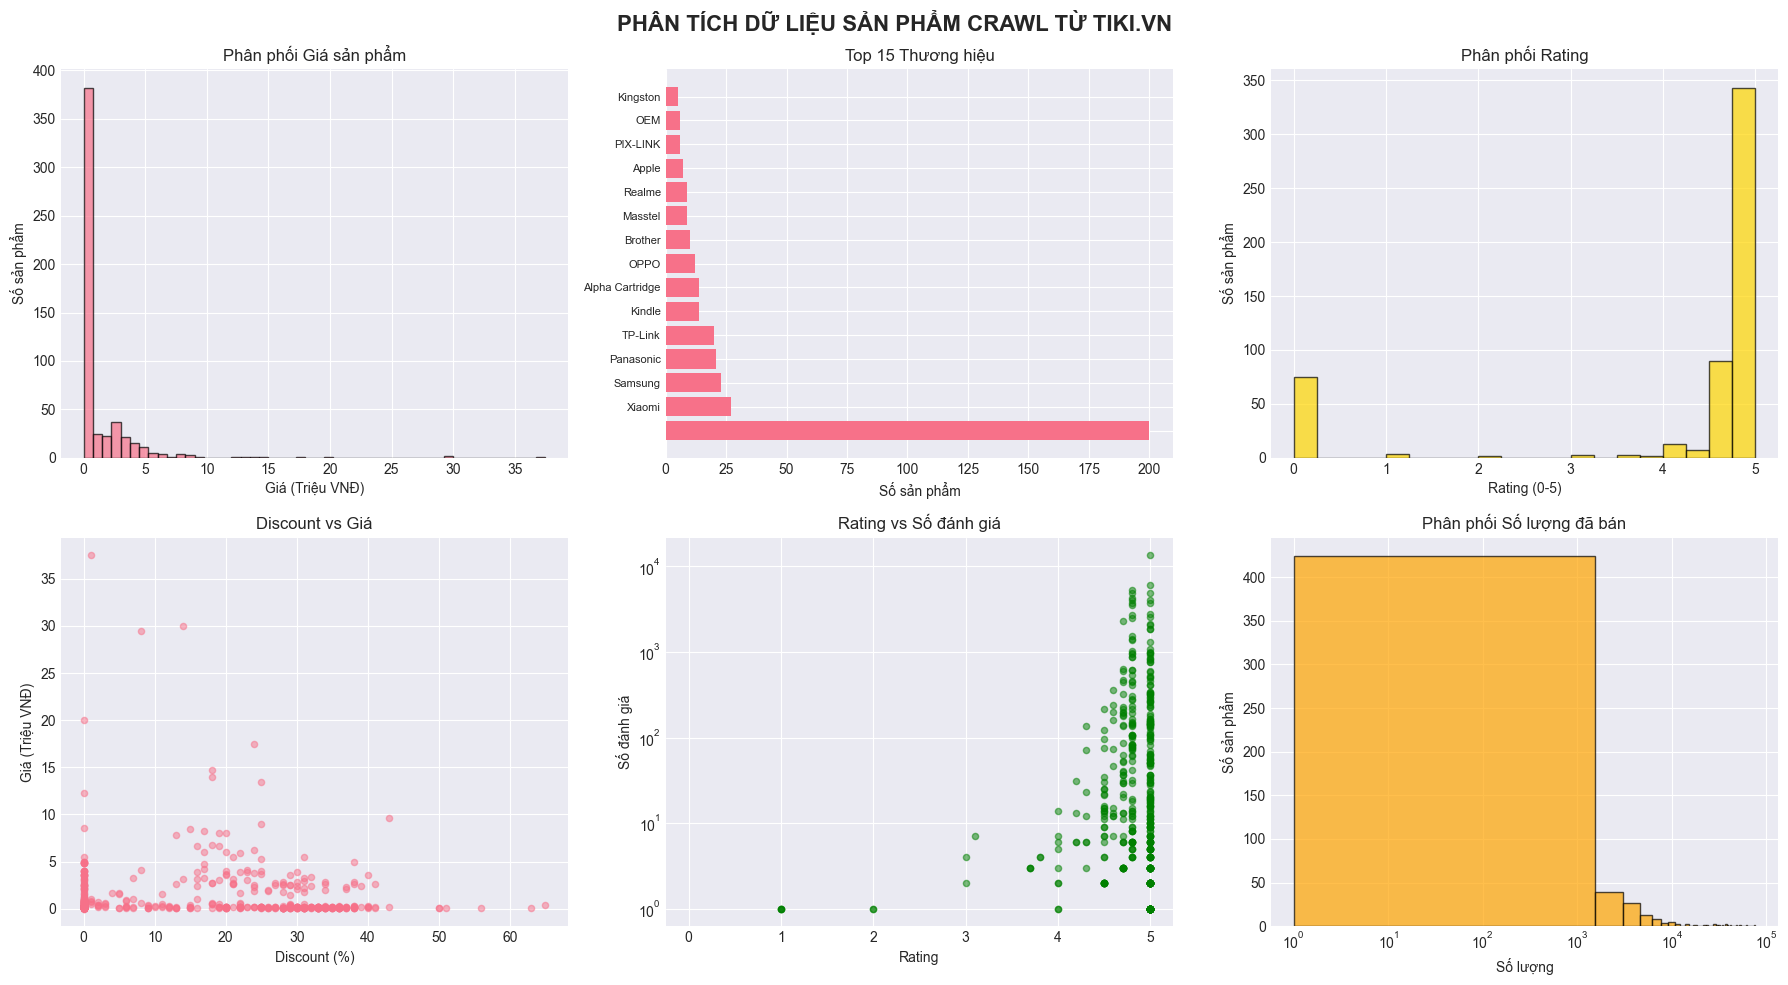

Saved chart: '01_tiki_products_analysis.png'


In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('PHÂN TÍCH DỮ LIỆU SẢN PHẨM CRAWL TỪ TIKI.VN', fontsize=16, fontweight='bold')

# 1. Phân phối giá sản phẩm
axes[0, 0].hist(df_products['price'][df_products['price'] > 0]/1000000, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Phân phối Giá sản phẩm')
axes[0, 0].set_xlabel('Giá (Triệu VNĐ)')
axes[0, 0].set_ylabel('Số sản phẩm')

# 2. Top 15 thương hiệu
top_brands = df_products['brand'].value_counts().head(15)
axes[0, 1].barh(range(len(top_brands)), top_brands.values)
axes[0, 1].set_yticks(range(len(top_brands)))
axes[0, 1].set_yticklabels(top_brands.index, fontsize=8)
axes[0, 1].set_title('Top 15 Thương hiệu')
axes[0, 1].set_xlabel('Số sản phẩm')

# 3. Phân phối Rating
axes[0, 2].hist(df_products['rating'], bins=20, edgecolor='black', alpha=0.7, color='gold')
axes[0, 2].set_title('Phân phối Rating')
axes[0, 2].set_xlabel('Rating (0-5)')
axes[0, 2].set_ylabel('Số sản phẩm')

# 4. Discount vs Price
axes[1, 0].scatter(df_products['discount'], df_products['price']/1000000, alpha=0.5, s=20)
axes[1, 0].set_title('Discount vs Giá')
axes[1, 0].set_xlabel('Discount (%)')
axes[1, 0].set_ylabel('Giá (Triệu VNĐ)')

# 5. Rating vs Review Count
axes[1, 1].scatter(df_products['rating'], df_products['review_count'], alpha=0.5, s=20, color='green')
axes[1, 1].set_title('Rating vs Số đánh giá')
axes[1, 1].set_xlabel('Rating')
axes[1, 1].set_ylabel('Số đánh giá')
axes[1, 1].set_yscale('log')

# 6. Sold Count Distribution
axes[1, 2].hist(df_products['sold_count'][df_products['sold_count'] > 0], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 2].set_title('Phân phối Số lượng đã bán')
axes[1, 2].set_xlabel('Số lượng')
axes[1, 2].set_ylabel('Số sản phẩm')
axes[1, 2].set_xscale('log')

plt.tight_layout()
plt.savefig('01_tiki_products_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved chart: '01_tiki_products_analysis.png'")

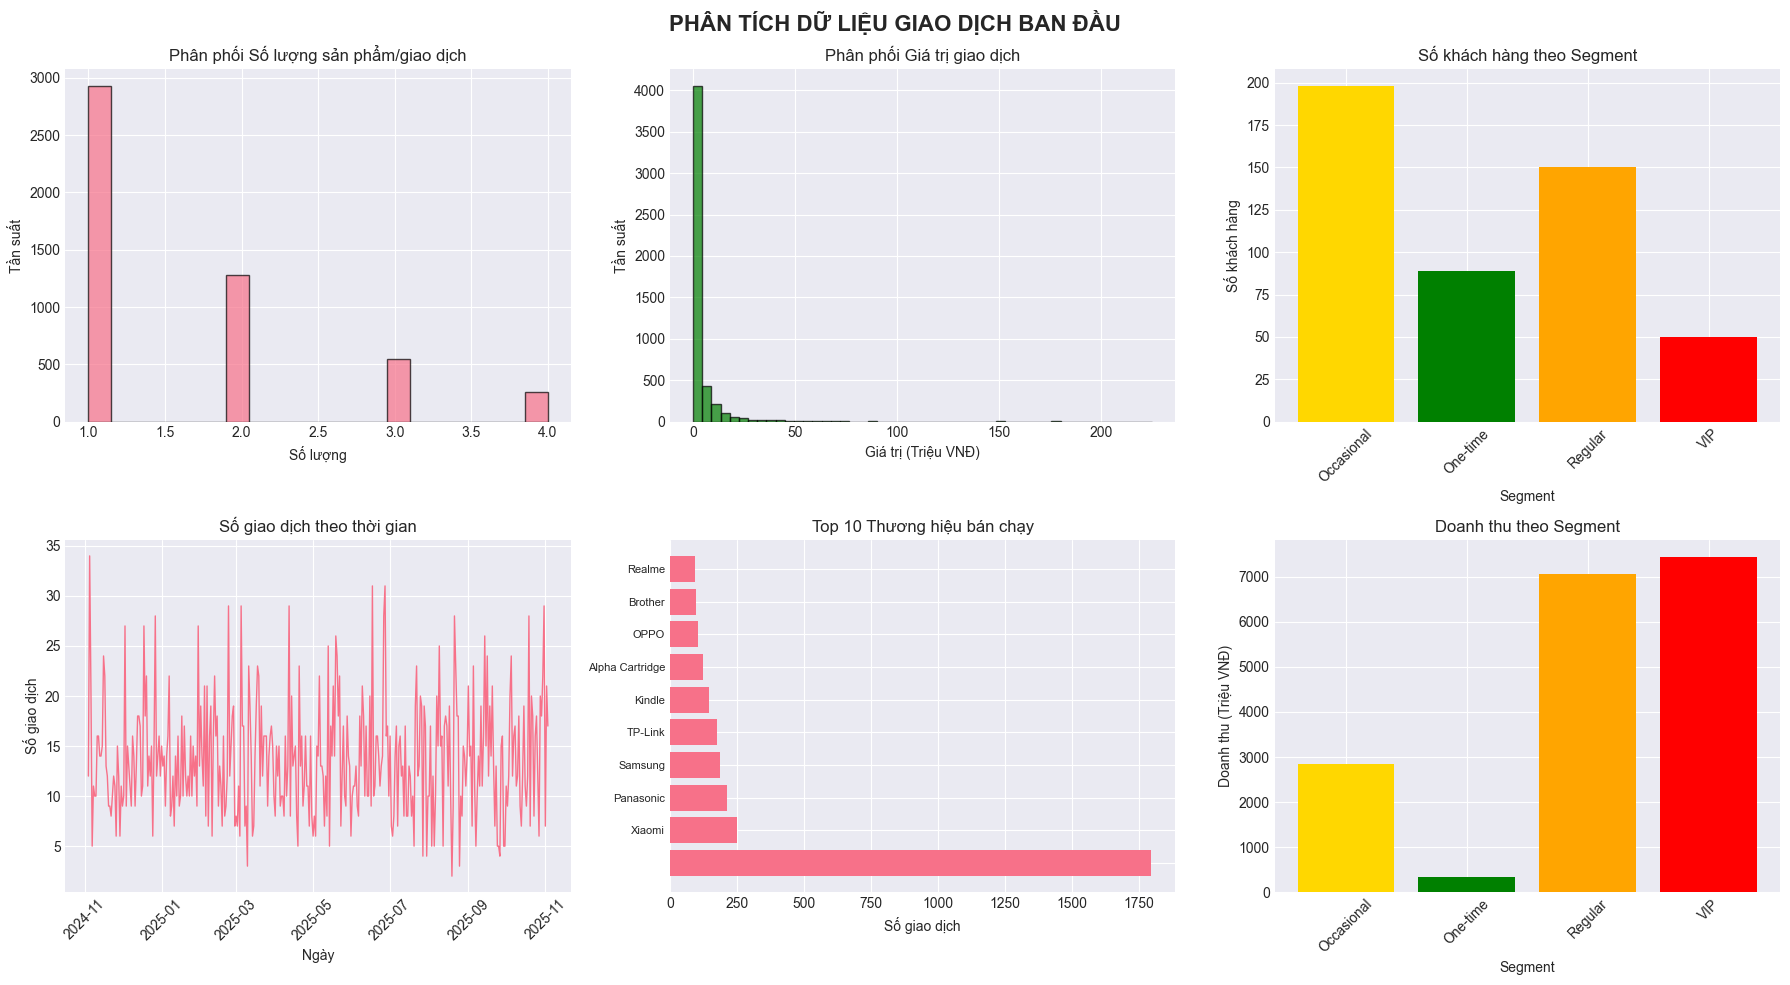

Saved chart: '02_raw_transactions_visualization.png'


In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('PHÂN TÍCH DỮ LIỆU GIAO DỊCH BAN ĐẦU', fontsize=16, fontweight='bold')

# 1. Phân phối số lượng mua
axes[0, 0].hist(df_raw['quantity'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Phân phối Số lượng sản phẩm/giao dịch')
axes[0, 0].set_xlabel('Số lượng')
axes[0, 0].set_ylabel('Tần suất')

# 2. Phân phối giá trị giao dịch
axes[0, 1].hist(df_raw['total_amount']/1000000, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Phân phối Giá trị giao dịch')
axes[0, 1].set_xlabel('Giá trị (Triệu VNĐ)')
axes[0, 1].set_ylabel('Tần suất')

# 3. Phân bố theo Customer Segment
segment_counts = df_raw.groupby('customer_segment')['customer_id'].nunique()
axes[0, 2].bar(segment_counts.index, segment_counts.values, color=['gold', 'green', 'orange', 'red'])
axes[0, 2].set_title('Số khách hàng theo Segment')
axes[0, 2].set_xlabel('Segment')
axes[0, 2].set_ylabel('Số khách hàng')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Giao dịch theo thời gian
df_raw['transaction_date'] = pd.to_datetime(df_raw['transaction_date'])
transactions_by_date = df_raw.groupby(df_raw['transaction_date'].dt.date).size()
axes[1, 0].plot(transactions_by_date.index, transactions_by_date.values, linewidth=1)
axes[1, 0].set_title('Số giao dịch theo thời gian')
axes[1, 0].set_xlabel('Ngày')
axes[1, 0].set_ylabel('Số giao dịch')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Top 10 thương hiệu được mua nhiều nhất
top_brands_sold = df_raw['brand'].value_counts().head(10)
axes[1, 1].barh(range(len(top_brands_sold)), top_brands_sold.values)
axes[1, 1].set_yticks(range(len(top_brands_sold)))
axes[1, 1].set_yticklabels(top_brands_sold.index, fontsize=8)
axes[1, 1].set_title('Top 10 Thương hiệu bán chạy')
axes[1, 1].set_xlabel('Số giao dịch')

# 6. Doanh thu theo segment
revenue_by_segment = df_raw.groupby('customer_segment')['total_amount'].sum()/1000000
axes[1, 2].bar(revenue_by_segment.index, revenue_by_segment.values, color=['gold', 'green', 'orange', 'red'])
axes[1, 2].set_title('Doanh thu theo Segment')
axes[1, 2].set_xlabel('Segment')
axes[1, 2].set_ylabel('Doanh thu (Triệu VNĐ)')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('02_raw_transactions_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved chart: '02_raw_transactions_visualization.png'")

In [10]:
print("DATA PREPROCESSING")
print("\nOverview:")
print(f"Number of transactions: {len(df_raw):,}")
print(f"Number of columns: {len(df_raw.columns)}")

print("\nMISSING VALUES:")
missing_stats = pd.DataFrame({
    'Quantity': df_raw.isnull().sum(),
    'Proportion (%)': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
})
print(missing_stats)

print("\nDUPLICATE VALUES:")
n_duplicates = df_raw.duplicated().sum()
print(f"Duplicate transaction number: {n_duplicates:,} ({n_duplicates/len(df_raw)*100:.2f}%)")

print("\nOUTLIERS:")
# Kiểm tra Quantity
q_negative = (df_raw['quantity'] < 0).sum()
q_zero = (df_raw['quantity'] == 0).sum()
print(f"Negative quantity: {q_negative:,}")
print(f"Positive quantity: {q_zero:,}")

# Kiểm tra Price
p_negative = (df_raw['unit_price'] < 0).sum()
p_zero = (df_raw['unit_price'] == 0).sum()
print(f"Negative unit price: {p_negative:,}")
print(f"Unit Price = 0: {p_zero:,}")

# Phát hiện outliers bằng IQR
Q1_qty = df_raw['quantity'].quantile(0.25)
Q3_qty = df_raw['quantity'].quantile(0.75)
IQR_qty = Q3_qty - Q1_qty
outliers_qty = ((df_raw['quantity'] < (Q1_qty - 1.5 * IQR_qty)) | 
                (df_raw['quantity'] > (Q3_qty + 1.5 * IQR_qty))).sum()
print(f"Outliers in Quantity (IQR): {outliers_qty:,} ({outliers_qty/len(df_raw)*100:.2f}%)")

Q1_price = df_raw['total_amount'].quantile(0.25)
Q3_price = df_raw['total_amount'].quantile(0.75)
IQR_price = Q3_price - Q1_price
outliers_price = ((df_raw['total_amount'] < (Q1_price - 1.5 * IQR_price)) | 
                  (df_raw['total_amount'] > (Q3_price + 1.5 * IQR_price))).sum()
print(f"Outliers in Total Amount (IQR): {outliers_price:,} ({outliers_price/len(df_raw)*100:.2f}%)")

print("\nDATA TYPES:")
print(df_raw.dtypes)

print("\nSTATISTICAL SUMMARY:")
print(df_raw[['quantity', 'unit_price', 'total_amount', 'rating']].describe())

print("\nBUSINESS INSIGHTS:")
print(f"Average transaction/customer: {len(df_raw)/df_raw['customer_id'].nunique():.2f}")
print(f"Average value/transaction: {df_raw['total_amount'].mean():,.0f} VNĐ")
print(f"Total revenue: {df_raw['total_amount'].sum():,.0f} VNĐ")

DATA PREPROCESSING

Overview:
Number of transactions: 5,000
Number of columns: 11

MISSING VALUES:
                  Quantity  Proportion (%)
transaction_id           0             0.0
customer_id              0             0.0
product_id               0             0.0
product_name             0             0.0
quantity                 0             0.0
unit_price               0             0.0
total_amount             0             0.0
transaction_date         0             0.0
brand                    0             0.0
rating                   0             0.0
customer_segment         0             0.0

DUPLICATE VALUES:
Duplicate transaction number: 0 (0.00%)

OUTLIERS:
Negative quantity: 0
Positive quantity: 0
Negative unit price: 0
Unit Price = 0: 0
Outliers in Quantity (IQR): 255 (5.10%)
Outliers in Total Amount (IQR): 732 (14.64%)

DATA TYPES:
transaction_id              object
customer_id                  int64
product_id                   int64
product_name                o

In [11]:
df_clean = df_raw.copy()
initial_rows = len(df_clean)

print("\nMissing Values")
before_missing = df_clean.isnull().sum().sum()
df_clean = df_clean.dropna()
after_missing = df_clean.isnull().sum().sum()
print(f"Removed: {before_missing - after_missing:,} missing values")
print(f"Remaining: {len(df_clean):,} transactions ({len(df_clean)/initial_rows*100:.2f}%)")

print("\nDuplicate Values")
before_dup = len(df_clean)
df_clean = df_clean.drop_duplicates()
removed_dup = before_dup - len(df_clean)
print(f"Removed: {removed_dup:,} duplicate transactions")
print(f"Remaining: {len(df_clean):,} transactions")

print("\nOutliers and Invalid Values")
before_outliers = len(df_clean)
# Loại bỏ giá trị âm và 0
df_clean = df_clean[(df_clean['quantity'] > 0) & (df_clean['unit_price'] > 0)]
# Loại bỏ outliers cực đoan (> 99th percentile hoặc < 1st percentile)
df_clean = df_clean[df_clean['quantity'] <= df_clean['quantity'].quantile(0.99)]
df_clean = df_clean[df_clean['total_amount'] <= df_clean['total_amount'].quantile(0.99)]
df_clean = df_clean[df_clean['total_amount'] >= df_clean['total_amount'].quantile(0.01)]
removed_outliers = before_outliers - len(df_clean)
print(f"Removed: {removed_outliers:,} outliers và invalid values")
print(f"Remaining: {len(df_clean):,} transactions")

print("\nData Normalization")
df_clean['transaction_date'] = pd.to_datetime(df_clean['transaction_date'])
df_clean['customer_id'] = df_clean['customer_id'].astype(int)
df_clean['product_id'] = df_clean['product_id'].astype(str)

print(f"\nData Summary:")
print(f"Initial transactions: {initial_rows:,}")
print(f"Processed transactions: {len(df_clean):,}")
print(f"Retention rate: {len(df_clean)/initial_rows*100:.2f}%")
print(f"Removed transactions: {initial_rows - len(df_clean):,}")

df_clean.to_csv('cleaned_transactions.csv', index=False, encoding='utf-8-sig')
print("\nSaved cleaned data to 'cleaned_transactions.csv'")


Missing Values
Removed: 0 missing values
Remaining: 5,000 transactions (100.00%)

Duplicate Values
Removed: 0 duplicate transactions
Remaining: 5,000 transactions

Outliers and Invalid Values
Removed: 98 outliers và invalid values
Remaining: 4,902 transactions

Data Normalization

Data Summary:
Initial transactions: 5,000
Processed transactions: 4,902
Retention rate: 98.04%
Removed transactions: 98

Saved cleaned data to 'cleaned_transactions.csv'


In [12]:
print("DATA AFTER PROCESSING")

print("\nOverview:")
print(f"Number of transactions: {len(df_clean):,}")
print(f"Number of columns: {len(df_clean.columns)}")

print("\nMISSING VALUES:")
missing_after = df_clean.isnull().sum().sum()
print(f"Total missing values: {missing_after}")

print("\nDUPLICATE VALUES:")
dup_after = df_clean.duplicated().sum()
print(f"Number of duplicate transactions: {dup_after}")

print("\nOUTLIERS:")
print(f"Negative quantity: {(df_clean['quantity'] < 0).sum()}")
print(f"Quantity = 0: {(df_clean['quantity'] == 0).sum()}")
print(f"Negative Unit Price: {(df_clean['unit_price'] < 0).sum()}")
print(f"Unit Price = 0: {(df_clean['unit_price'] == 0).sum()}")

print("\nDATA TYPES:")
print(df_clean.dtypes)

print("\nSTATISTICAL SUMMARY:")
print(df_clean[['quantity', 'unit_price', 'total_amount', 'rating']].describe())

print("\nBefore - after processing:")
comparison = pd.DataFrame({
    'Metric': ['Số giao dịch', 'Missing Values', 'Duplicates', 'Outliers'],
    'Trước': [initial_rows, before_missing, n_duplicates, outliers_qty + outliers_price],
    'Sau': [len(df_clean), missing_after, dup_after, 0],
    'Giảm': [initial_rows - len(df_clean), before_missing - missing_after, 
             n_duplicates - dup_after, outliers_qty + outliers_price]
})
print(comparison.to_string(index=False))

DATA AFTER PROCESSING

Overview:
Number of transactions: 4,902
Number of columns: 11

MISSING VALUES:
Total missing values: 0

DUPLICATE VALUES:
Number of duplicate transactions: 0

OUTLIERS:
Negative quantity: 0
Quantity = 0: 0
Negative Unit Price: 0
Unit Price = 0: 0

DATA TYPES:
transaction_id              object
customer_id                  int64
product_id                  object
product_name                object
quantity                     int64
unit_price                 float64
total_amount               float64
transaction_date    datetime64[ns]
brand                       object
rating                     float64
customer_segment            object
dtype: object

STATISTICAL SUMMARY:
          quantity    unit_price  total_amount       rating
count  4902.000000  4.902000e+03  4.902000e+03  4902.000000
mean      1.621379  1.871141e+06  2.867216e+06     4.102856
std       0.867147  3.596666e+06  5.568821e+06     1.725079
min       1.000000  1.900000e+04  3.750000e+04     0.000

Data comparison

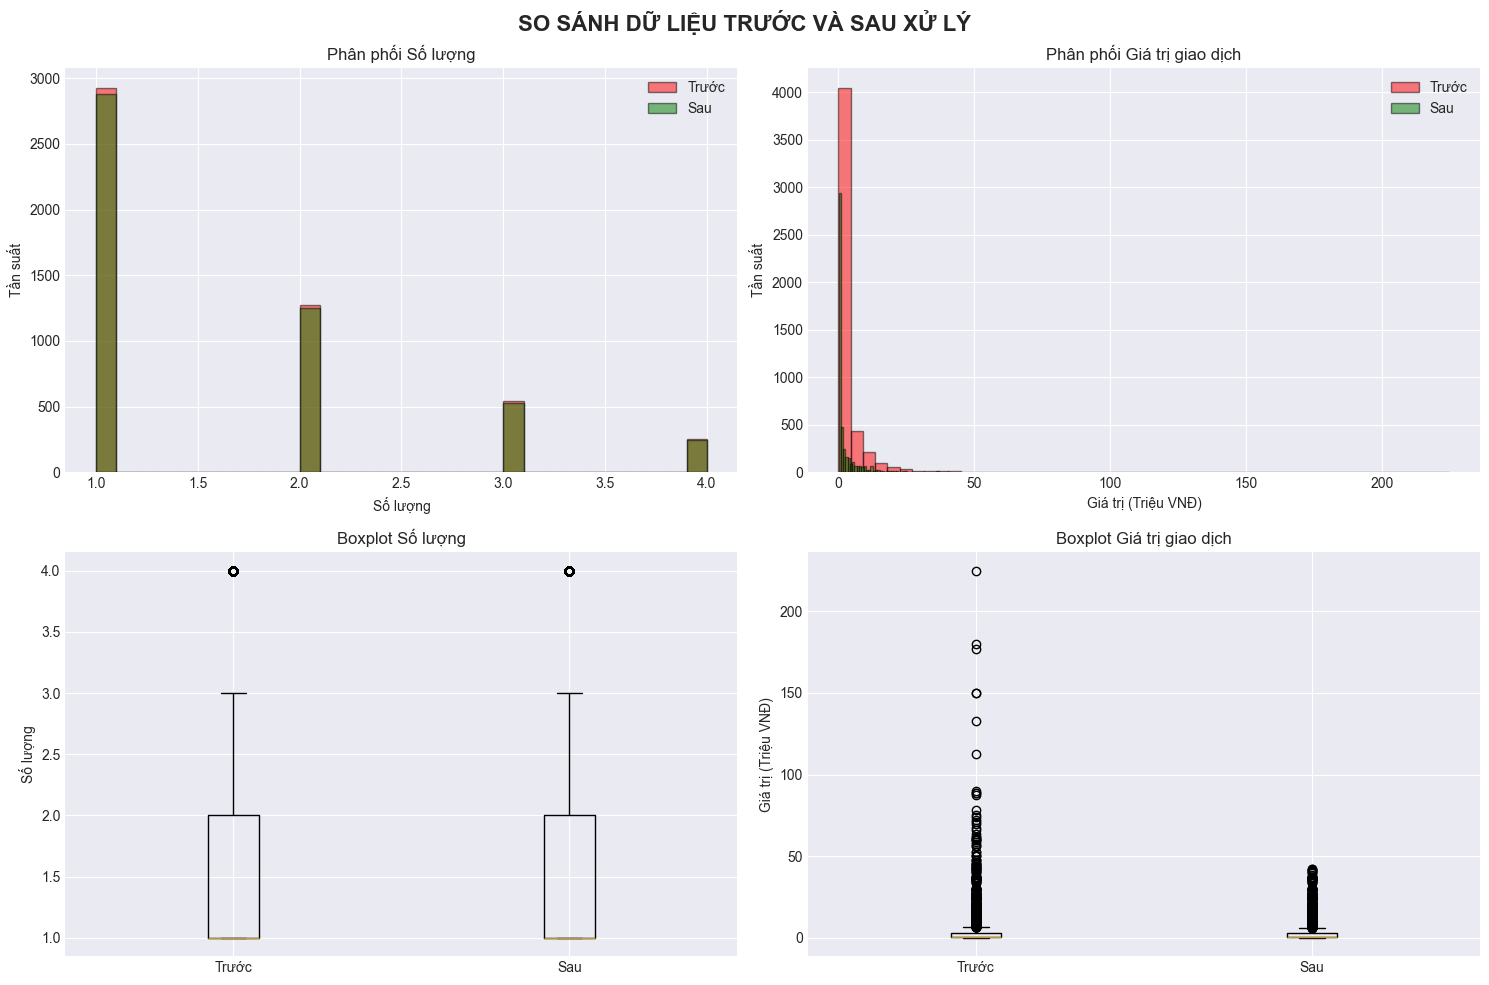

Saved chart: '03_before_after_comparison.png'


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('SO SÁNH DỮ LIỆU TRƯỚC VÀ SAU XỬ LÝ', fontsize=16, fontweight='bold')

# 1. Phân phối Quantity
axes[0, 0].hist(df_raw['quantity'], bins=30, alpha=0.5, label='Trước', color='red', edgecolor='black')
axes[0, 0].hist(df_clean['quantity'], bins=30, alpha=0.5, label='Sau', color='green', edgecolor='black')
axes[0, 0].set_title('Phân phối Số lượng')
axes[0, 0].set_xlabel('Số lượng')
axes[0, 0].set_ylabel('Tần suất')
axes[0, 0].legend()

# 2. Phân phối Total Amount
axes[0, 1].hist(df_raw['total_amount']/1000000, bins=50, alpha=0.5, label='Trước', color='red', edgecolor='black')
axes[0, 1].hist(df_clean['total_amount']/1000000, bins=50, alpha=0.5, label='Sau', color='green', edgecolor='black')
axes[0, 1].set_title('Phân phối Giá trị giao dịch')
axes[0, 1].set_xlabel('Giá trị (Triệu VNĐ)')
axes[0, 1].set_ylabel('Tần suất')
axes[0, 1].legend()

# 3. Boxplot Quantity
axes[1, 0].boxplot([df_raw['quantity'], df_clean['quantity']], 
                    labels=['Trước', 'Sau'])
axes[1, 0].set_title('Boxplot Số lượng')
axes[1, 0].set_ylabel('Số lượng')

# 4. Boxplot Total Amount
axes[1, 1].boxplot([df_raw['total_amount']/1000000, df_clean['total_amount']/1000000], 
                    labels=['Trước', 'Sau'])
axes[1, 1].set_title('Boxplot Giá trị giao dịch')
axes[1, 1].set_ylabel('Giá trị (Triệu VNĐ)')

plt.tight_layout()
plt.savefig('03_before_after_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved chart: '03_before_after_comparison.png'")

Create RFM features

In [14]:
print("CREATE RFM FEATURES (Recency, Frequency, Monetary)")
# Tính ngày reference (ngày cuối cùng trong dataset + 1)
reference_date = df_clean['transaction_date'].max() + timedelta(days=1)
print(f"Reference Date: {reference_date}")
# Tính RFM cho mỗi khách hàng
rfm = df_clean.groupby('customer_id').agg({
    'transaction_date': lambda x: (reference_date - x.max()).days,  # Recency
    'transaction_id': 'nunique',  # Frequency
    'total_amount': 'sum'  # Monetary
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
# Thêm các feature bổ sung
customer_extra = df_clean.groupby('customer_id').agg({
    'quantity': 'sum',  # Tổng sản phẩm đã mua
    'rating': 'mean',  # Rating trung bình của sản phẩm đã mua
    'brand': lambda x: x.nunique()  # Số lượng thương hiệu khác nhau
}).reset_index()
customer_extra.columns = ['CustomerID', 'TotalProducts', 'AvgRating', 'BrandDiversity']
# Merge RFM với features bổ sung
rfm = rfm.merge(customer_extra, on='CustomerID')
# Tính thêm Average Order Value
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

print(f"\nCreated RFM features for {len(rfm)} customer")
print("\nFeatures created:")
print(rfm.columns.tolist())

print("\nRFM Statistics:")
print(rfm.describe())

print("\nSome RFM Data Samples:")
display(rfm.head(10))

rfm.to_csv('rfm_features.csv', index=False, encoding='utf-8-sig')
print("\nSaved RFM features to 'rfm_features.csv'")

CREATE RFM FEATURES (Recency, Frequency, Monetary)
Reference Date: 2025-11-04 13:53:07.688371



Created RFM features for 487 customer

Features created:
['CustomerID', 'Recency', 'Frequency', 'Monetary', 'TotalProducts', 'AvgRating', 'BrandDiversity', 'AvgOrderValue']

RFM Statistics:
         CustomerID     Recency   Frequency      Monetary  TotalProducts  \
count    487.000000  487.000000  487.000000  4.870000e+02     487.000000   
mean   10244.691992   81.710472   10.065708  2.886056e+07      16.320329   
std      142.891940   85.651776    8.688469  3.775472e+07      14.082504   
min    10000.000000    1.000000    1.000000  3.840000e+04       1.000000   
25%    10121.500000   17.000000    4.000000  4.739397e+06       6.000000   
50%    10243.000000   50.000000    8.000000  1.454574e+07      12.000000   
75%    10366.500000  116.000000   13.000000  3.823079e+07      22.000000   
max    10499.000000  364.000000   49.000000  2.362187e+08      77.000000   

        AvgRating  BrandDiversity  AvgOrderValue  
count  487.000000      487.000000   4.870000e+02  
mean     4.018154     

,CustomerID,Recency,Frequency,Monetary,TotalProducts,AvgRating,BrandDiversity,AvgOrderValue
0,10000,1,26,111455845.0,50,4.657692,12,4.286763e+06
1,10001,8,39,113534242.5,67,3.602564,22,2.911134e+06
2,10002,17,15,107377190.0,25,4.566667,6,7.158479e+06
3,10003,40,22,57181445.0,38,4.845455,11,2.599157e+06
4,10004,13,22,54471052.5,36,4.050000,12,2.475957e+06
5,10005,28,13,87784250.0,21,4.076923,12,6.752635e+06
6,10006,78,16,99862000.0,34,4.056250,11,6.241375e+06
7,10007,1,30,51790260.0,45,4.513333,13,1.726342e+06
8,10008,15,25,88994307.5,44,3.772000,11,3.559772e+06
9,10009,16,36,212854175.0,63,3.883333,22,5.912616e+06



Saved RFM features to 'rfm_features.csv'


EDA

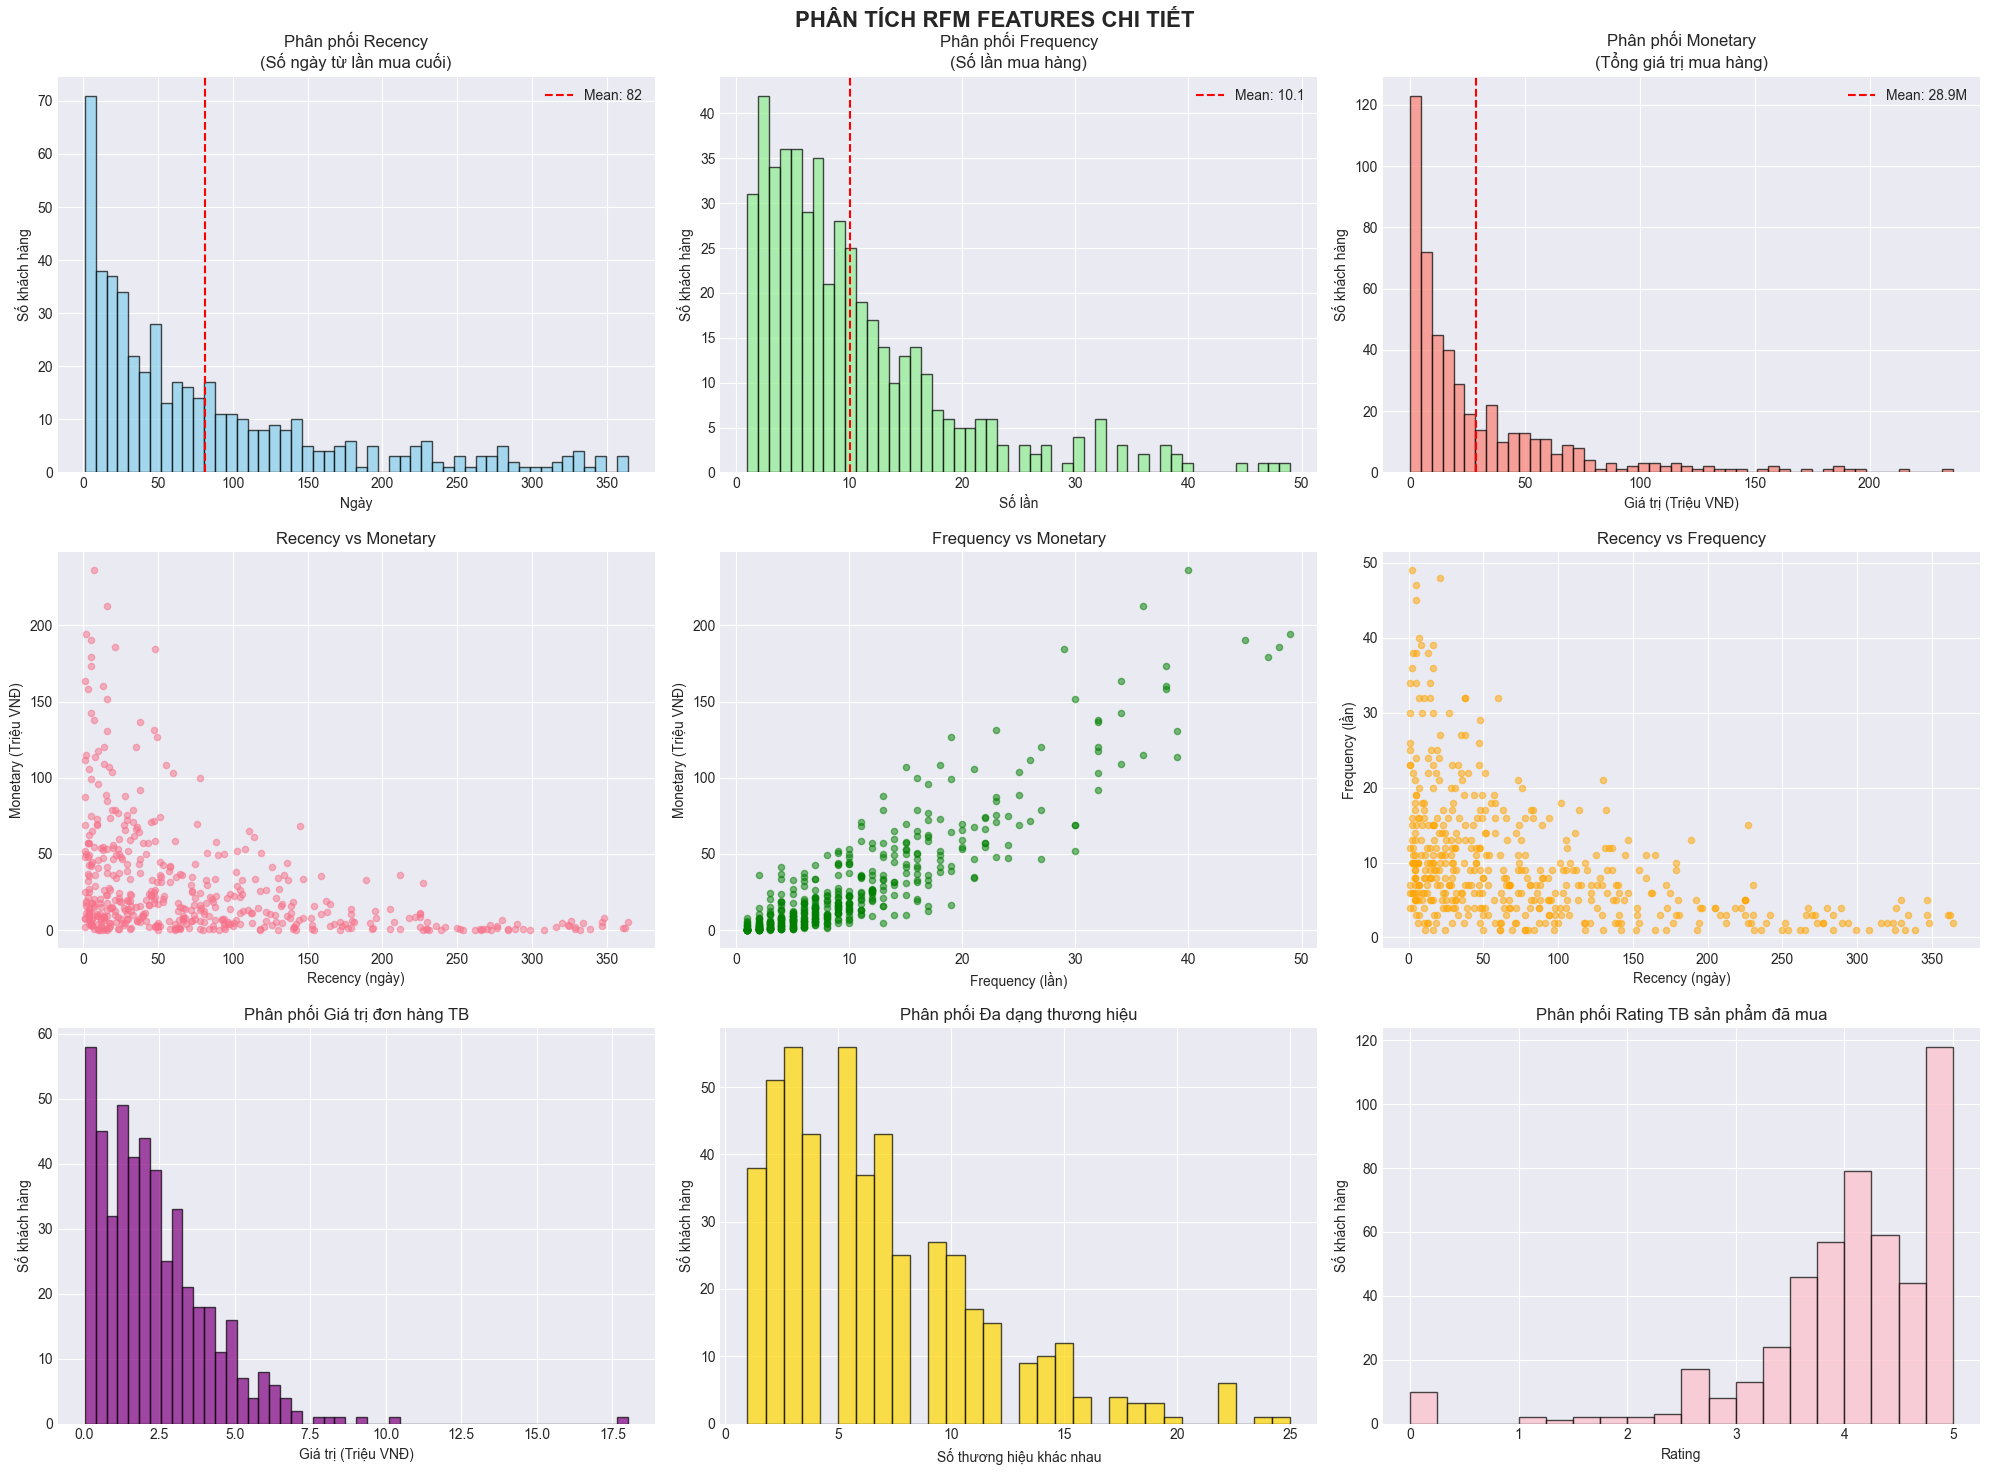

Saved chart: '04_rfm_analysis.png'


In [15]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('PHÂN TÍCH RFM FEATURES CHI TIẾT', fontsize=16, fontweight='bold')

# 1. Phân phối Recency
axes[0, 0].hist(rfm['Recency'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_title('Phân phối Recency\n(Số ngày từ lần mua cuối)')
axes[0, 0].set_xlabel('Ngày')
axes[0, 0].set_ylabel('Số khách hàng')
axes[0, 0].axvline(rfm['Recency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Recency"].mean():.0f}')
axes[0, 0].legend()

# 2. Phân phối Frequency
axes[0, 1].hist(rfm['Frequency'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Phân phối Frequency\n(Số lần mua hàng)')
axes[0, 1].set_xlabel('Số lần')
axes[0, 1].set_ylabel('Số khách hàng')
axes[0, 1].axvline(rfm['Frequency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Frequency"].mean():.1f}')
axes[0, 1].legend()

# 3. Phân phối Monetary
axes[0, 2].hist(rfm['Monetary']/1000000, bins=50, edgecolor='black', alpha=0.7, color='salmon')
axes[0, 2].set_title('Phân phối Monetary\n(Tổng giá trị mua hàng)')
axes[0, 2].set_xlabel('Giá trị (Triệu VNĐ)')
axes[0, 2].set_ylabel('Số khách hàng')
axes[0, 2].axvline(rfm['Monetary'].mean()/1000000, color='red', linestyle='--', label=f'Mean: {rfm["Monetary"].mean()/1000000:.1f}M')
axes[0, 2].legend()

# 4. Scatter: Recency vs Monetary
axes[1, 0].scatter(rfm['Recency'], rfm['Monetary']/1000000, alpha=0.5, s=20)
axes[1, 0].set_title('Recency vs Monetary')
axes[1, 0].set_xlabel('Recency (ngày)')
axes[1, 0].set_ylabel('Monetary (Triệu VNĐ)')

# 5. Scatter: Frequency vs Monetary
axes[1, 1].scatter(rfm['Frequency'], rfm['Monetary']/1000000, alpha=0.5, s=20, color='green')
axes[1, 1].set_title('Frequency vs Monetary')
axes[1, 1].set_xlabel('Frequency (lần)')
axes[1, 1].set_ylabel('Monetary (Triệu VNĐ)')

# 6. Scatter: Recency vs Frequency
axes[1, 2].scatter(rfm['Recency'], rfm['Frequency'], alpha=0.5, s=20, color='orange')
axes[1, 2].set_title('Recency vs Frequency')
axes[1, 2].set_xlabel('Recency (ngày)')
axes[1, 2].set_ylabel('Frequency (lần)')

# 7. Phân phối Average Order Value
axes[2, 0].hist(rfm['AvgOrderValue']/1000000, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[2, 0].set_title('Phân phối Giá trị đơn hàng TB')
axes[2, 0].set_xlabel('Giá trị (Triệu VNĐ)')
axes[2, 0].set_ylabel('Số khách hàng')

# 8. Phân phối Brand Diversity
axes[2, 1].hist(rfm['BrandDiversity'], bins=30, edgecolor='black', alpha=0.7, color='gold')
axes[2, 1].set_title('Phân phối Đa dạng thương hiệu')
axes[2, 1].set_xlabel('Số thương hiệu khác nhau')
axes[2, 1].set_ylabel('Số khách hàng')

# 9. Phân phối Average Rating
axes[2, 2].hist(rfm['AvgRating'], bins=20, edgecolor='black', alpha=0.7, color='pink')
axes[2, 2].set_title('Phân phối Rating TB sản phẩm đã mua')
axes[2, 2].set_xlabel('Rating')
axes[2, 2].set_ylabel('Số khách hàng')

plt.tight_layout()
plt.savefig('04_rfm_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved chart: '04_rfm_analysis.png'")

Correlation matrix

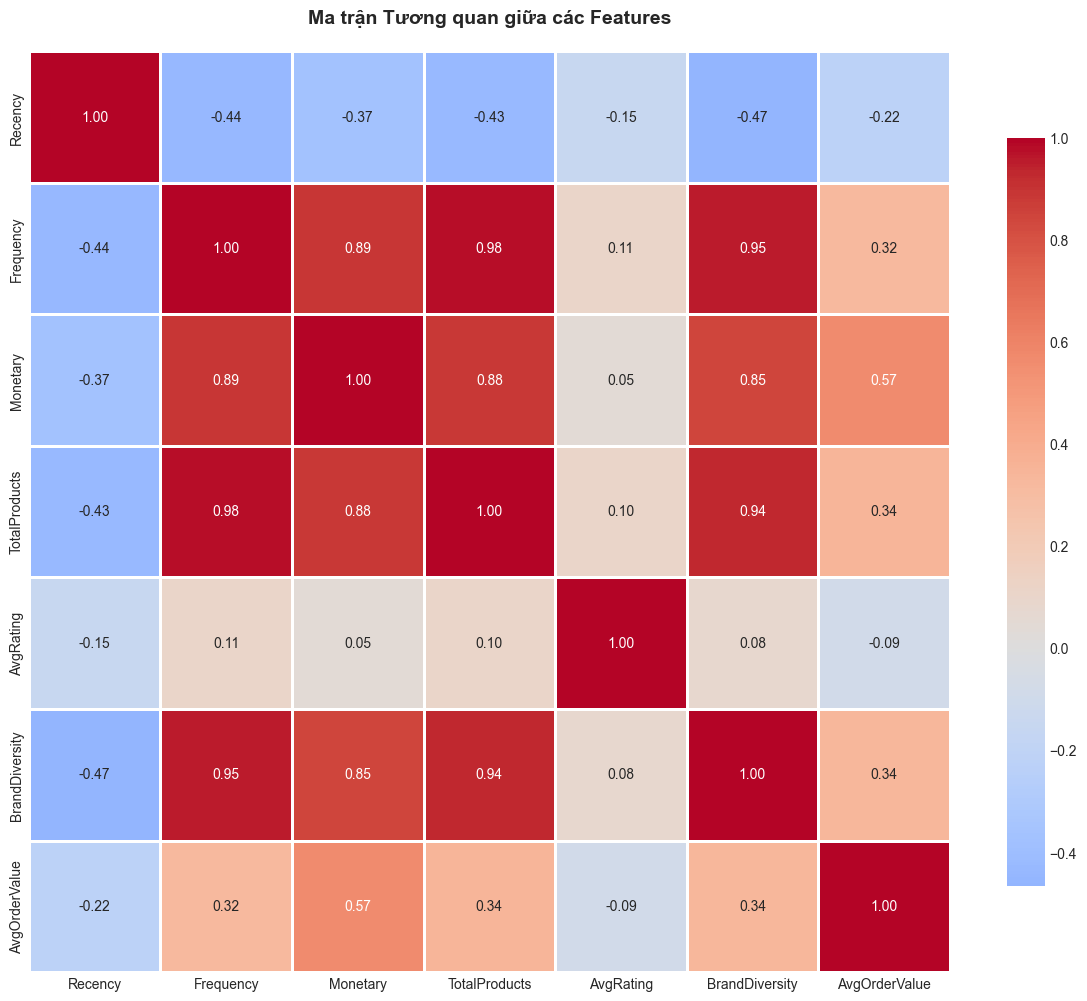

Saved chart: '05_correlation_matrix.png'

KEY CORRELATION ANALYSIS:

Strong correlation (|r| > 0.7):
   Frequency <-> Monetary: 0.892
   Frequency <-> TotalProducts: 0.982
   Frequency <-> BrandDiversity: 0.953
   Monetary <-> TotalProducts: 0.884
   Monetary <-> BrandDiversity: 0.849
   TotalProducts <-> BrandDiversity: 0.937

Average correlation (0.4 < |r| < 0.7):
   Recency <-> Frequency: -0.440
   Recency <-> TotalProducts: -0.432
   Recency <-> BrandDiversity: -0.465
   Monetary <-> AvgOrderValue: 0.570


In [16]:
# Chọn các cột số để phân tích tương quan
numeric_cols = ['Recency', 'Frequency', 'Monetary', 'TotalProducts', 'AvgRating', 'BrandDiversity', 'AvgOrderValue']
correlation_matrix = rfm[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Ma trận Tương quan giữa các Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('05_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved chart: '05_correlation_matrix.png'")

print("\nKEY CORRELATION ANALYSIS:")
print("\nStrong correlation (|r| > 0.7):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            print(f"   {correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {corr_value:.3f}")

print("\nAverage correlation (0.4 < |r| < 0.7):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if 0.4 < abs(corr_value) <= 0.7:
            print(f"   {correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {corr_value:.3f}")


Before Kmeans

In [17]:
# Chọn features cho clustering (loại bỏ CustomerID)
features_for_clustering = ['Recency', 'Frequency', 'Monetary', 'TotalProducts', 'BrandDiversity', 'AvgOrderValue']
X = rfm[features_for_clustering].copy()

print(f"Features used for clustering: {features_for_clustering}")
print(f"Data shape: {X.shape}")

# Log transform cho các features có phân phối lệch
print("\nApply Log Transformation to features:")
X['Monetary_log'] = np.log1p(X['Monetary'])
X['AvgOrderValue_log'] = np.log1p(X['AvgOrderValue'])
X = X.drop(['Monetary', 'AvgOrderValue'], axis=1)
print("Done.")

# Kiểm tra và xử lý outliers bằng IQR
print("\nSolving outliers using IQR:")
for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    outliers_count = ((X[col] < lower_bound) | (X[col] > upper_bound)).sum()
    if outliers_count > 0:
        print(f"{col}: {outliers_count} outliers detected")
        X[col] = X[col].clip(lower=lower_bound, upper=upper_bound)

# Chuẩn hóa dữ liệu (Standardization)
print("\nData normalization:")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("Done.")

print("\nStatistics after normalization:")
print(X_scaled_df.describe())

Features used for clustering: ['Recency', 'Frequency', 'Monetary', 'TotalProducts', 'BrandDiversity', 'AvgOrderValue']
Data shape: (487, 6)

Apply Log Transformation to features:
Done.

Solving outliers using IQR:
Frequency: 4 outliers detected
TotalProducts: 2 outliers detected

Data normalization:
Done.

Statistics after normalization:
            Recency     Frequency  TotalProducts  BrandDiversity  \
count  4.870000e+02  4.870000e+02   4.870000e+02      487.000000   
mean  -2.918040e-17 -5.836080e-17  -5.836080e-17        0.000000   
std    1.001028e+00  1.001028e+00   1.001028e+00        1.001028   
min   -9.432783e-01 -1.066463e+00  -1.093999e+00       -1.218824   
25%   -7.562834e-01 -7.112182e-01  -7.364784e-01       -0.785088   
50%   -3.706062e-01 -2.375590e-01  -3.074533e-01       -0.351353   
75%    4.007481e-01  3.545149e-01   4.075885e-01        0.516119   
max    3.299170e+00  3.551714e+00   3.839789e+00        3.986005   

       Monetary_log  AvgOrderValue_log  
count 

Find optimal k with Elbow Method

K=2: Inertia = 1646.06
K=3: Inertia = 1070.17
K=4: Inertia = 852.36
K=5: Inertia = 695.80
K=6: Inertia = 607.60
K=7: Inertia = 525.94
K=8: Inertia = 456.96
K=9: Inertia = 420.71
K=10: Inertia = 392.88

Elbow Method suggests optimal K = 3


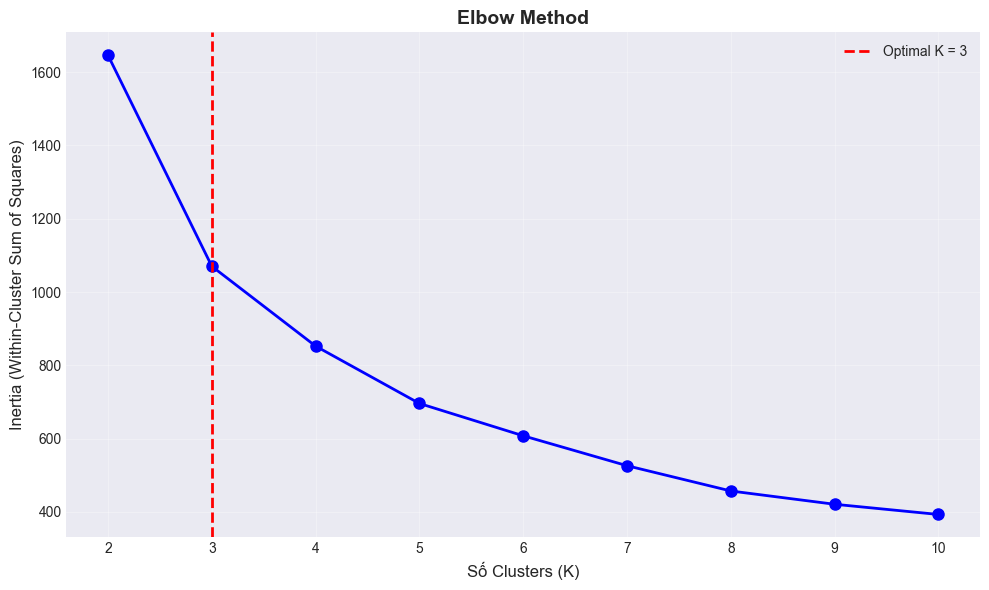

Saved chart: '06_elbow_method.png'


In [18]:
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(f"K={k}: Inertia = {kmeans.inertia_:.2f}")

# Tính toán elbow point bằng phương pháp gradient
differences = []
for i in range(1, len(inertias)):
    diff = inertias[i-1] - inertias[i]
    differences.append(diff)

# Tìm điểm có sự thay đổi lớn nhất (elbow)
max_diff_idx = differences.index(max(differences))
best_k = K_range[max_diff_idx + 1]

print(f"\nElbow Method suggests optimal K = {best_k}")

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'Optimal K = {best_k}')
plt.xlabel('Số Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('06_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved chart: '06_elbow_method.png'")

Kmeans

In [19]:
print(f"K = {best_k}")
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=20, max_iter=300)
kmeans_final.fit(X_scaled)

# Dự đoán cluster cho mỗi khách hàng
rfm['Cluster'] = kmeans_final.labels_

print(f"Divided {len(rfm)} customers into {best_k} clusters")

print("\nCUSTOMER CLUSTERING:")
cluster_counts = rfm['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster +1}: {count} customers ({count/len(rfm)*100:.2f}%)")

# Thống kê trung bình của mỗi cluster
print("\nCLUSTER CHARACTERISTIC:")
# Sử dụng các cột gốc thay vì log-transformed columns
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary', 'TotalProducts', 'BrandDiversity', 'AvgOrderValue']].mean()
display(cluster_summary)

# Các cluster
def name_cluster(row):
    if row['Frequency'] > rfm['Frequency'].quantile(0.75) and row['Monetary'] > rfm['Monetary'].quantile(0.75):
        return 'VIP Customers'
    elif row['Recency'] < rfm['Recency'].quantile(0.25) and row['Frequency'] > rfm['Frequency'].median():
        return 'Loyal Customers'
    elif row['Recency'] > rfm['Recency'].quantile(0.75):
        return 'At Risk'
    elif row['Frequency'] <= rfm['Frequency'].quantile(0.25):
        return 'New Customers'
    else:
        return 'Regular Customers'

cluster_names = cluster_summary.apply(name_cluster, axis=1)
print("\nCLUSTERS:")
for cluster, name in cluster_names.items():
    print(f"   Cluster {cluster}: {name}")
rfm['ClusterName'] = rfm['Cluster'].map(cluster_names)

rfm.to_csv('customer_segments.csv', index=False, encoding='utf-8-sig')
print("\nSaved customer clustering into 'customer_segments.csv'")

K = 3
Divided 487 customers into 3 clusters

CUSTOMER CLUSTERING:
Cluster 1: 280 customers (57.49%)
Cluster 2: 98 customers (20.12%)
Cluster 3: 109 customers (22.38%)

CLUSTER CHARACTERISTIC:


,Recency,Frequency,Monetary,TotalProducts,BrandDiversity,AvgOrderValue
Cluster,,,,,,
0,62.682143,8.042857,1.962537e+07,13.092857,5.789286,2.597867e+06
1,28.255102,23.877551,8.543176e+07,38.734694,13.846939,3.519981e+06
2,178.651376,2.844037,1.721783e+06,4.458716,2.256881,6.484518e+05



CLUSTERS:
   Cluster 0: Regular Customers
   Cluster 1: VIP Customers
   Cluster 2: At Risk

Saved customer clustering into 'customer_segments.csv'


Visualization clustering result

Number of clusters used: 3
PC1: 71.39%
PC2: 14.82%
Total: 86.21%


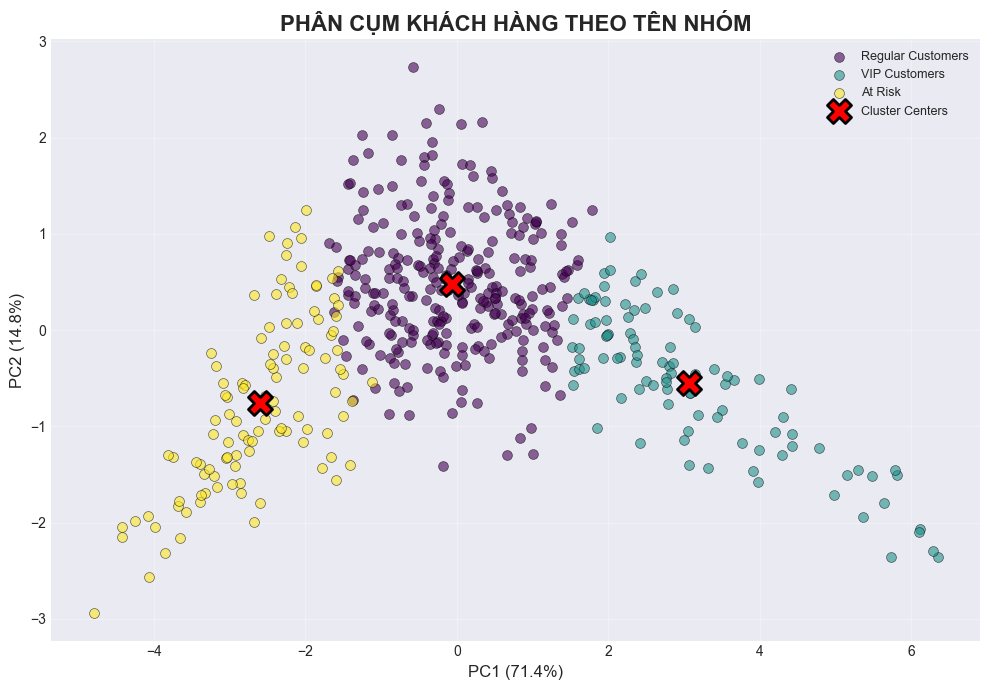

Saved chart: '07_clustering_visualization_2d.png'

STATISTICS OF 3 CLUSTER

Regular Customers (Cluster 0): 280 customers
Monetary TB: 19,625,369 VNĐ
Frequency TB: 8.0 lần
Recency TB: 62.7 ngày
AOV TB: 2,597,867 VNĐ

VIP Customers (Cluster 1): 98 customers
Monetary TB: 85,431,765 VNĐ
Frequency TB: 23.9 lần
Recency TB: 28.3 ngày
AOV TB: 3,519,981 VNĐ

At Risk (Cluster 2): 109 customers
Monetary TB: 1,721,783 VNĐ
Frequency TB: 2.8 lần
Recency TB: 178.7 ngày
AOV TB: 648,452 VNĐ


In [ ]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"Number of clusters used: {best_k}")
print(f"PC1: {pca_2d.explained_variance_ratio_[0]*100:.2f}%")
print(f"PC2: {pca_2d.explained_variance_ratio_[1]*100:.2f}%")
print(f"Total: {sum(pca_2d.explained_variance_ratio_)*100:.2f}%")

plt.figure(figsize=(10, 7))
plt.title('PHÂN CỤM KHÁCH HÀNG THEO TÊN NHÓM', fontsize=16, fontweight='bold')
# Màu cho từng cụm
colors = plt.cm.viridis(np.linspace(0, 1, best_k))

# Vẽ các cụm với tên
for i, cluster_name in cluster_names.items():
    cluster_data = X_pca_2d[rfm['Cluster'] == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                c=[colors[i]], label=cluster_name, s=50, alpha=0.6, 
                edgecolors='black', linewidth=0.5)

# Vẽ tâm cụm
centers_2d = pca_2d.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], 
            c='red', marker='X', s=300, edgecolors='black', linewidth=2,
            label='Cluster Centers')

# Nhãn trục và chú thích
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=9)

# Lưu và hiển thị
plt.tight_layout()
plt.savefig('07_clustering_visualization_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved chart: '07_clustering_visualization_2d.png'")

# Giữ lại phần thống kê chi tiết
print(f"\nSTATISTICS OF {best_k} CLUSTER")
for cluster_id, cluster_name in cluster_names.items():
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    print(f"\n{cluster_name} (Cluster {cluster_id}): {len(cluster_data)} customers")
    print(f"Monetary TB: {cluster_data['Monetary'].mean():,.0f} VNĐ")
    print(f"Frequency TB: {cluster_data['Frequency'].mean():.1f} lần")
    print(f"Recency TB: {cluster_data['Recency'].mean():.1f} ngày")
    print(f"AOV TB: {cluster_data['AvgOrderValue'].mean():,.0f} VNĐ")


Visualization 3D clustering result

Variance:
PC1: 71.39%
PC2: 14.82%
PC3: 11.89%
Total: 98.10%


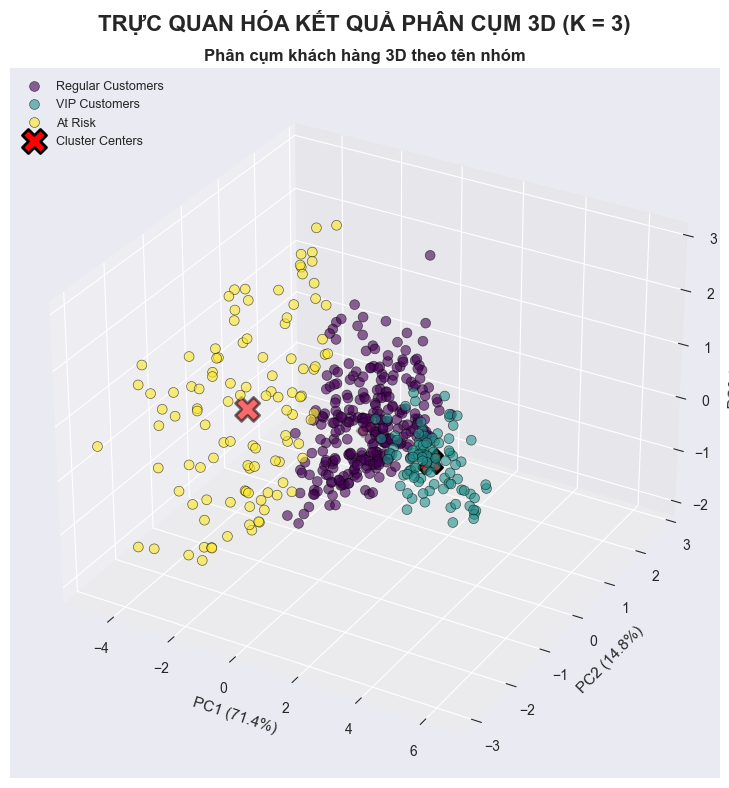

Saved chart: '08_clustering_visualization_3d.png'


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

print(f"Variance:")
print(f"PC1: {pca_3d.explained_variance_ratio_[0]*100:.2f}%")
print(f"PC2: {pca_3d.explained_variance_ratio_[1]*100:.2f}%")
print(f"PC3: {pca_3d.explained_variance_ratio_[2]*100:.2f}%")
print(f"Total: {sum(pca_3d.explained_variance_ratio_)*100:.2f}%")
# Tạo biểu đồ 3D
fig = plt.figure(figsize=(20, 8))
# Vẽ cluster centers 3D
centers_3d = pca_3d.transform(kmeans_final.cluster_centers_)

# 3D với cluster names
ax2 = fig.add_subplot(111, projection='3d')
colors = plt.cm.viridis(np.linspace(0, 1, best_k))

for i, cluster_name in cluster_names.items():
    cluster_data_3d = X_pca_3d[rfm['Cluster'] == i]
    ax2.scatter(cluster_data_3d[:, 0], cluster_data_3d[:, 1], cluster_data_3d[:, 2],
               c=[colors[i]], label=cluster_name, s=50, alpha=0.6,
               edgecolors='black', linewidth=0.5)

# Vẽ cluster centers cho subplot 2
ax2.scatter(centers_3d[:, 0], centers_3d[:, 1], centers_3d[:, 2],
           c='red', marker='X', s=300, edgecolors='black', linewidth=2,
           label='Cluster Centers')

ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11)
ax2.set_title('Phân cụm khách hàng 3D theo tên nhóm', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=9)

plt.suptitle(f'TRỰC QUAN HÓA KẾT QUẢ PHÂN CỤM 3D (K = {best_k})', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('08_clustering_visualization_3d.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved chart: '08_clustering_visualization_3d.png'")
